In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
#from scipy.optimize import curve_fit

#import scvi
import pickle
from adjustText import adjust_text

import itertools
#from numba import jit

import gseapy as gp
import random
import matplotlib.patheffects as PathEffects

In [2]:
with open('../data/gene_lists/mouse_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role
senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist() #FIX MOUSE
senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}
markers = markers | senmayo

In [3]:
with open('../data/files/5_TMS_HUBS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    hubs = pickle.load(handle)
    
hub_metadata = pd.read_pickle('../data/files/5_TMS_HUBS_METADATA_FILTERED.pickle')

with open('../data/files/5_TMS_SIGS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    signatures = pickle.load(handle)
    
sig_metadata = pd.read_pickle('../data/files/5_TMS_SIGS_METADATA_FILTERED.pickle')

In [4]:
#get organismal aging gene lists

df = pd.read_csv('../data/gene_lists/elife-62293-supp2-v2-1_aging_genes.csv')


def tissue_gene_lis(tissue_cell):
    return list(df[df[tissue_cell] == 1].gene.values)

organismal = {}
for tissue_cell in [x for x in df.columns if x != 'gene']:
    organismal[tissue_cell] = tissue_gene_lis(tissue_cell)

In [5]:
adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data.h5ad')
global_gene_len = len(adata.var_names)

In [7]:
out = []
for a,b in tqdm(list(itertools.combinations(list(hubs) + list(organismal), r = 2))):
    
    if '.' in a:
        aa = organismal[a]
    else:
        aa = [x[0] for x in hubs[a]]
  
    if '.' in b:
        bb = organismal[b]
    else:
        bb = [x[0] for x in hubs[b]]

    overlap = len([x for x in aa if x in bb])
    
    p = stats.hypergeom.sf(overlap-1, global_gene_len, len(aa), len(bb))
    
    
    if len(a) == 3:
        a = '-'.join([str(x) for x in a])
    if len(b) == 3:
        b = '-'.join([str(x) for x in b])
    
    out.append([a, b, p])
    

100%|████████████████████████████████████| 11325/11325 [01:06<00:00, 169.64it/s]


In [8]:
for a in tqdm(list(hubs) + list(organismal)):
    if '.' in a:
        aa = organismal[a]
    else:
        aa = [x[0] for x in hubs[a]]
  
    overlap = len([x for x in aa if x in list(markers)])
    
    p = stats.hypergeom.sf(overlap-1, global_gene_len, len(aa), len(markers))
    
    if len(a) == 3:
        a = '-'.join([str(x) for x in a])
    
    out.append([a, 'senescence', p])

100%|████████████████████████████████████████| 151/151 [00:00<00:00, 498.59it/s]


In [9]:
#could add universal signature too?

In [10]:
df = pd.DataFrame(out, columns = ['a', 'b', 'p'])

df = df.sort_values('p').reset_index(drop = True)

df['FDR'] = df.p * len(df)

df['FDR'] = df['FDR'].replace(0, 4.9406564584124654e-324)

df['nlogFDR'] = -np.log10(df.FDR)

In [11]:
df

,a,b,p,FDR,nlogFDR
0,Brain_Non-Myeloid.endothelial cell,Skin.bulge keratinocyte,0.0,4.940656e-324,323.306215
1,Large_Intestine.intestinal crypt stem cell,Trachea.fibroblast,0.0,4.940656e-324,323.306215
2,Brain_Non-Myeloid.endothelial cell,Heart.endothelial cell of coronary artery,0.0,4.940656e-324,323.306215
3,Limb_Muscle.mesenchymal stem cell,Lung.adventitial cell,0.0,4.940656e-324,323.306215
4,Heart.endothelial cell of coronary artery,Heart.fibroblast of cardiac tissue,0.0,4.940656e-324,323.306215
...,...,...,...,...,...
11471,Large_Intestine-secretory cell-0,Kidney.kidney collecting duct epithelial cell,1.0,1.147600e+04,-4.059791
11472,Large_Intestine-secretory cell-0,Kidney.fenestrated cell,1.0,1.147600e+04,-4.059791
11473,Large_Intestine-secretory cell-0,Heart.valve cell,1.0,1.147600e+04,-4.059791
11474,Large_Intestine-secretory cell-0,Lung.fibroblast of lung,1.0,1.147600e+04,-4.059791


In [12]:
df2 = df[df.FDR <= 0.05].copy()
#df2['width'] = (df2.nlogFDR/324)*100
df2

,a,b,p,FDR,nlogFDR
0,Brain_Non-Myeloid.endothelial cell,Skin.bulge keratinocyte,0.000000,4.940656e-324,323.306215
1,Large_Intestine.intestinal crypt stem cell,Trachea.fibroblast,0.000000,4.940656e-324,323.306215
2,Brain_Non-Myeloid.endothelial cell,Heart.endothelial cell of coronary artery,0.000000,4.940656e-324,323.306215
3,Limb_Muscle.mesenchymal stem cell,Lung.adventitial cell,0.000000,4.940656e-324,323.306215
4,Heart.endothelial cell of coronary artery,Heart.fibroblast of cardiac tissue,0.000000,4.940656e-324,323.306215
...,...,...,...,...,...
3261,Limb_Muscle-macrophage-0,Lymphoid-NK cell-2,0.000004,4.758755e-02,1.322507
3262,HSC-hematopoietic stem cell-2,Lung-alveolar macrophage-2,0.000004,4.801901e-02,1.318587
3263,Brain_Non-Myeloid.oligodendrocyte precursor cell,Kidney.kidney collecting duct epithelial cell,0.000004,4.854367e-02,1.313867
3264,Lymphoid-B cell-1,Trachea-macrophage-1,0.000004,4.884091e-02,1.311216


In [13]:
import networkx as nx
import networkx.algorithms.community as nx_comm

/tmp/ipykernel_1753478/2696816309.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[0], elrow[1], weight=elrow[4]) #, width=elrow[5]


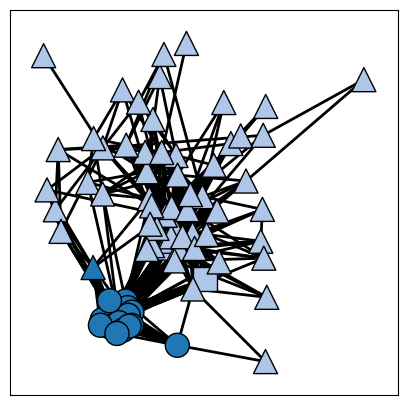

In [14]:
G = nx.Graph()

for i, elrow in df2.iterrows():
    G.add_edge(elrow[0], elrow[1], weight=elrow[4]) #, width=elrow[5]
    


clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(5,5))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items() if k in markers}

# nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
#                         font_weight='bold')




for component in list(nx.connected_components(G)):
    if len(component)<3:
        for node in component:
            G.remove_node(node)


shape_d = dict(zip(['-'.join([str(y) for y in x]) for x in list(hubs)], ['^']*len(hubs))) |\
dict(zip(list(organismal), ['o']*len(organismal))) | {'senescence': 's'}


for node in G.nodes(data=True):
    G.nodes(data=True)[node[0]]['s'] = shape_d[node[0]]
            
            

#Get all distinct node classes according to the node shape attribute
nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data = True)))

#For each node class...
for aShape in nodeShapes:
    nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))]
    #...filter and draw the subset of nodes with the same symbol in the positions that are now known through the use of the layout.
    nx.draw_networkx_nodes(G,pos,node_shape = aShape,nodelist = nodelist,
                          node_color = [color_d[x[0]] for x in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))],
                          edgecolors='k')
   
            
#widths = [G[u][v]['width'] for u,v in G.edges()]
            
# nx.draw_networkx_nodes(G, pos, 
#                        node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
#                        ) #edgecolors

nx.draw_networkx_edges(G, pos, width = 2)

texts = []
for k in node_lables:
    txt = plt.text(x = node_lables[k][0], y = node_lables[k][1], s = k,
                             fontsize = 15, weight = 'bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    texts.append(txt)

adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))

#plt.savefig('for_poster/mouse_heart_myocyte_network.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [ ]:
#this looks good but try signatures instead because hubs from the same cell do not ahve the same genes
#therefore will have 0 overlap

In [15]:
out = []
for a,b in tqdm(list(itertools.combinations(list(signatures) + list(organismal), r = 2))):
    
    if '.' in a:
        aa = organismal[a]
    else:
        aa = [x[0] for x in signatures[a]]
  
    if '.' in b:
        bb = organismal[b]
    else:
        bb = [x[0] for x in signatures[b]]

    overlap = len([x for x in aa if x in bb])
    
    p = stats.hypergeom.sf(overlap-1, global_gene_len, len(aa), len(bb))
    
    
    if len(a) == 2:
        a = '-'.join([str(x) for x in a])
    if len(b) == 2:
        b = '-'.join([str(x) for x in b])
    
    out.append([a, b, p])
    
    
for a in tqdm(list(signatures) + list(organismal)):
    if '.' in a:
        aa = organismal[a]
    else:
        aa = [x[0] for x in signatures[a]]
  
    overlap = len([x for x in aa if x in list(markers)])
    
    p = stats.hypergeom.sf(overlap-1, global_gene_len, len(aa), len(markers))
    
    if len(a) == 2:
        a = '-'.join([str(x) for x in a])
    
    out.append([a, 'senescence', p])
    
df = pd.DataFrame(out, columns = ['a', 'b', 'p'])

df = df.sort_values('p').reset_index(drop = True)

df['FDR'] = df.p * len(df)

df['FDR'] = df['FDR'].replace(0, 4.9406564584124654e-324)

df['nlogFDR'] = -np.log10(df.FDR)

df

100%|████████████████████████████████████████| 123/123 [00:00<00:00, 382.30it/s]


,a,b,p,FDR,nlogFDR
0,Marrow.late pro-B cell,Marrow.promonocyte,0.0,4.940656e-324,323.306215
1,Limb_Muscle.skeletal muscle satellite cell,Tongue.keratinocyte,0.0,4.940656e-324,323.306215
2,Limb_Muscle.skeletal muscle satellite cell,Trachea.fibroblast,0.0,4.940656e-324,323.306215
3,Diaphragm.skeletal muscle satellite cell,Limb_Muscle.mesenchymal stem cell,0.0,4.940656e-324,323.306215
4,Diaphragm.skeletal muscle satellite cell,Limb_Muscle.skeletal muscle satellite cell,0.0,4.940656e-324,323.306215
...,...,...,...,...,...
7621,Liver-hepatocyte,Diaphragm.mesenchymal stem cell,1.0,7.626000e+03,-3.882297
7622,Diaphragm-mesenchymal stem cell,Lung.adventitial cell,1.0,7.626000e+03,-3.882297
7623,Liver-hepatocyte,Brain_Non-Myeloid.oligodendrocyte,1.0,7.626000e+03,-3.882297
7624,HSC-hematopoietic stem cell,Kidney.kidney collecting duct epithelial cell,1.0,7.626000e+03,-3.882297


In [16]:
df3 = df[df.FDR <= 0.001].copy()
df3['width'] = (df2.nlogFDR/324)*25
df3['width'][df3['width'] > 10] = 10
df3

/tmp/ipykernel_1753478/1221581818.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df3['width'][df3['width'] > 10] = 10
/tmp/ipykernel_1753478/1221581818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,a,b,p,FDR,nlogFDR,width
0,Marrow.late pro-B cell,Marrow.promonocyte,0.000000e+00,4.940656e-324,323.306215,10.000000
1,Limb_Muscle.skeletal muscle satellite cell,Tongue.keratinocyte,0.000000e+00,4.940656e-324,323.306215,10.000000
2,Limb_Muscle.skeletal muscle satellite cell,Trachea.fibroblast,0.000000e+00,4.940656e-324,323.306215,10.000000
3,Diaphragm.skeletal muscle satellite cell,Limb_Muscle.mesenchymal stem cell,0.000000e+00,4.940656e-324,323.306215,10.000000
4,Diaphragm.skeletal muscle satellite cell,Limb_Muscle.skeletal muscle satellite cell,0.000000e+00,4.940656e-324,323.306215,10.000000
...,...,...,...,...,...,...
3058,Fat-endothelial cell,Large_Intestine-epithelial cell,9.250958e-08,7.054780e-04,3.151517,0.325973
3059,Heart_and_Aorta-fibroblast,Kidney-podocyte,9.550700e-08,7.283364e-04,3.137668,0.325005
3060,Kidney.kidney collecting duct epithelial cell,Skin.bulge keratinocyte,1.025617e-07,7.821353e-04,3.106718,0.321311
3061,Lymphoid-NK cell,Trachea-basal cell,1.110283e-07,8.467021e-04,3.072269,0.316403


### Fig 2E

/tmp/ipykernel_1753478/297255901.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[0], elrow[1], weight=elrow[4], width=elrow[5]) #,


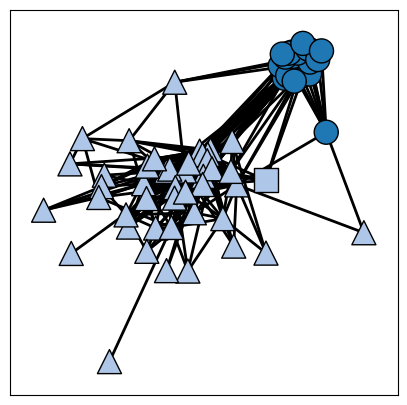

In [18]:
G = nx.Graph()

for i, elrow in df3.iterrows():
    G.add_edge(elrow[0], elrow[1], weight=elrow[4], width=elrow[5]) #, 
    


clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(5,5))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items()}

# nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
#                         font_weight='bold')




for component in list(nx.connected_components(G)):
    if len(component)<3:
        for node in component:
            G.remove_node(node)


shape_d = dict(zip(['-'.join([str(y) for y in x]) for x in list(signatures)], ['^']*len(hubs))) |\
dict(zip(list(organismal), ['o']*len(organismal))) | {'senescence': 's'}


for node in G.nodes(data=True):
    G.nodes(data=True)[node[0]]['s'] = shape_d[node[0]]
            
            

#Get all distinct node classes according to the node shape attribute
nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data = True)))

#For each node class...
for aShape in nodeShapes:
    nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))]
    #...filter and draw the subset of nodes with the same symbol in the positions that are now known through the use of the layout.
    nx.draw_networkx_nodes(G,pos,node_shape = aShape,nodelist = nodelist,
                          node_color = [color_d[x[0]] for x in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))],
                          edgecolors='k')
   
            
widths = [G[u][v]['width'] for u,v in G.edges()]
            
# nx.draw_networkx_nodes(G, pos, 
#                        node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
#                        ) #edgecolors

nx.draw_networkx_edges(G, pos, width = 2) #width = widths

# texts = []
# txt = plt.text(x = node_lables['senescence'][0], y = node_lables['senescence'][1], s = 'SnC markers',
#                          fontsize = 11, weight = 'bold', ha = 'left', va = 'center')
# txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])


#texts.append(txt)

#adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))

plt.savefig('figures/2E.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/2E.svg', bbox_inches = 'tight')

plt.show()

In [204]:
{k:v for (k,v) in pos.items()}

{'Marrow.late pro-B cell': array([0.13046651, 0.1662011 ]),
 'Marrow.promonocyte': array([0.12680727, 0.17123603]),
 'Limb_Muscle.skeletal muscle satellite cell': array([0.15354398, 0.18005348]),
 'Tongue.keratinocyte': array([0.15772879, 0.15938661]),
 'Trachea.fibroblast': array([0.14250435, 0.20788105]),
 'Diaphragm.skeletal muscle satellite cell': array([0.16585851, 0.16476196]),
 'Limb_Muscle.mesenchymal stem cell': array([0.17657599, 0.20083403]),
 'Brain_Non-Myeloid.brain pericyte': array([0.17988029, 0.20388249]),
 'Marrow.hematopoietic stem cell': array([0.14056676, 0.19129577]),
 'Mammary_Gland.basal cell': array([0.17881272, 0.1802896 ]),
 'Marrow.granulocytopoietic cell': array([0.14284694, 0.18142188]),
 'Marrow.precursor B cell': array([0.14016018, 0.17895054]),
 'Tongue.basal cell of epidermis': array([0.13850746, 0.19389716]),
 'Heart.endothelial cell of coronary artery': array([0.13861415, 0.20846523]),
 'SCAT.endothelial cell': array([0.16309844, 0.2235351 ]),
 'Skin.

In [23]:
df['as'] = df.a.map(shape_d)
df['bs'] = df.b.map(shape_d)

In [33]:
df[(df['as'] == '^') & (df.bs == '^') & (df.FDR< 0.05)]

,a,b,p,FDR,nlogFDR,as,bs
508,Diaphragm-mesenchymal stem cell-2,Diaphragm-skeletal muscle satellite cell-1,5.816735e-225,6.675285e-221,220.175530,^,^
803,Trachea-basal cell -1,Trachea-fibroblast-0,2.292711e-165,2.631115e-161,160.579860,^,^
926,Lung-fibroblast-1,Trachea-fibroblast-0,4.283217e-147,4.915420e-143,142.308439,^,^
977,Diaphragm-mesenchymal stem cell-2,Trachea-fibroblast-0,4.310744e-141,4.947010e-137,136.305657,^,^
1113,Diaphragm-skeletal muscle satellite cell-1,Trachea-fibroblast-0,2.122968e-128,2.436318e-124,123.613266,^,^
...,...,...,...,...,...,...,...
3257,Heart_and_Aorta-endocardial cell-1,Kidney-collecting duct principal cell-0,3.832851e-06,4.398580e-02,1.356688,^,^
3260,Heart_and_Aorta-fibroblast-1,Liver-Kupffer cell-1,4.012562e-06,4.604817e-02,1.336788,^,^
3261,Limb_Muscle-macrophage-0,Lymphoid-NK cell-2,4.146702e-06,4.758755e-02,1.322507,^,^
3262,HSC-hematopoietic stem cell-2,Lung-alveolar macrophage-2,4.184299e-06,4.801901e-02,1.318587,^,^


In [29]:
hub_metadata

,tissue,cell,hub_num,size,n_sen,hyp
0,Bladder,bladder cell,0,20,0,1.000000
1,Bladder,bladder cell,1,36,0,1.000000
2,Bladder,bladder cell,2,61,2,0.107390
3,Bladder,endothelial cell,1,29,0,1.000000
4,Diaphragm,mesenchymal stem cell,0,88,0,1.000000
...,...,...,...,...,...,...
70,Trachea,basal cell,1,495,16,0.000013
71,Trachea,fibroblast,0,680,21,0.000001
72,Trachea,fibroblast,1,74,2,0.147080
73,Trachea,macrophage,0,1654,23,0.028732


In [30]:
75*75

5625